# Part 2: Extension Plan

The primary industries in Kansas are agriculture and manufacturing. These industries are particularly vulnerable to te growing threat of wildfire smoke, which reduces air quality in the area. This porblem is becoming more prevalent with climate change which prolongs wildfire seasons and causing smoke to trael beyond its source. Understanding how persistent exposure to wildfire smoke impacts health, economy, services, and etc. can allow us to better plan for future prevention actions and mitigate future risks. 
This section is aimed to help inform the city council, city manager/ mayor, and city residents about the potential future impacts of smoke on their community.

Use the following block to install libraries needed to run this notebook.

In [ ]:
# %%capture
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn
# %pip install lxml
# %pip install openpyxl
# %pip install requests
# %pip install fbprophet

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import nnls
from prophet import Prophet


Run the following cell if you wish to view all rows in a dataframe. I have the cell commented out as I don't wish to have all cells displayed.

In [5]:
# pd.set_option('display.max_rows', None) 

Next, we read in the data from part 1 of this project. 

In [169]:
wildfire_df =  pd.read_csv("../intermediate_data/wildfire.csv")
aqi_df = pd.read_csv("../intermediate_data/avg_aqi_per_year.csv")

Next, we filter the wildfire data again, just in case. 

In [170]:
wildfire_df = wildfire_df[
    (wildfire_df["Year"] >= 1961) & 
    (wildfire_df["Year"] <= 2021) & 
    (wildfire_df["Distance"] <= 650)
].reset_index()

In [179]:
wildfire_df.shape

(26044, 6)

I noticed that in Part 1 I did not plot smoke impact against AQI for comparison. I expect that AQI and smoke impact to have a strong correlation, so I am plotting it out to check my hypothesis.     
The wildfire data that I exported does not contain the expected or predicted smokes. Therefore I am using repeating the steps to estimate and predict smoke. 

While I am repeating steps, there are changes that I made to make the model more reasonable. The weights of fire types were adjusted as I would like to accomodate for uncertainty (such as factors like wind direction and intensity that we are not considering), and produce a more balanced prediction for all fire types.

In [171]:
fire_type_weights = {
    "Wildfire": 0.4,
    "Likely Wildfire": 0.30,
    "Prescribed Fire": 0.20,
    "Unknown - Likely Wildfire": 0.15,
    "Unknown - Likely Prescribed Fire": 0.05
}
wildfire_df["Fire_Weight"] = wildfire_df["Fire_Type"].map(fire_type_weights)
wildfire_df.head(3)

,index,Year,Acres,Distance,Fire_Type,Fire_Weight
0,23,1961,9870.377328,521.435188,Wildfire,0.4
1,24,1961,4995.989520,519.809326,Wildfire,0.4
2,25,1961,4995.932412,524.776604,Wildfire,0.4


In [172]:
wildfire_df = wildfire_df.drop(columns= "index")

In [173]:
wildfire_df["Estimated_Smoke"] =  (wildfire_df["Acres"] / (wildfire_df["Distance"])**2)

In [174]:
wildfire_df_model = wildfire_df.drop(columns= "Fire_Type")
grouped_wildfire_df = wildfire_df.groupby("Year").agg(avg_smoke=("Estimated_Smoke", "mean")).reset_index()
grouped_wildfire_df.head(3)


,Year,avg_smoke
0,1961,0.003492
1,1962,0.002820
2,1963,0.000613


In [175]:
grouped_wildfire_df["avg_smoke"] *=100

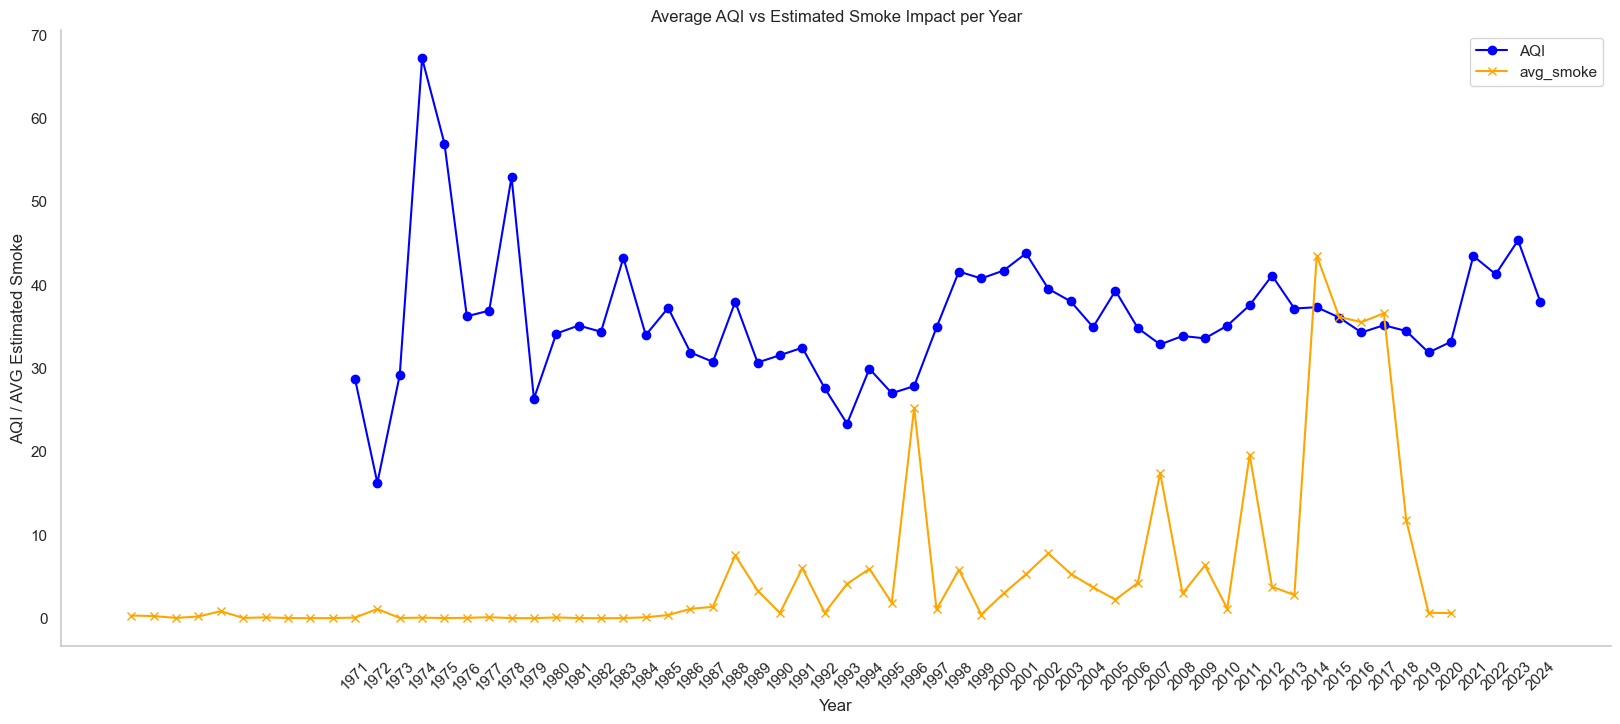

In [ ]:
plt.figure(figsize=(20, 8))

plt.plot(aqi_df["year"], aqi_df["avg_aqi"], marker="o", linestyle="-", label="AQI", color="blue")

plt.plot(grouped_wildfire_df["Year"], grouped_wildfire_df["avg_smoke"], marker="x", linestyle="-", label="avg_smoke", color="orange")

plt.title("Average AQI vs Estimated Smoke Impact per Year")
plt.xlabel("Year")
plt.ylabel("AQI / AVG Estimated Smoke")

plt.grid(False)
plt.xticks(aqi_df["year"], rotation=45) 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.legend()
plt.savefig("../graphs/aqi_vs_smoke_impact")
plt.show()

Observing this graph, we see a weak correlation between the average AQI, and the average estimated smoke impact per year. This suggests that our formula for estimated smoke might not be capturing the key relationships, or that we are not including some important features.

In [ ]:
aqi_df.rename(columns={"year": "Year"}, inplace=True)
merged_df = pd.merge(aqi_df[["Year", "avg_aqi"]], grouped_wildfire_df[["Year", "avg_smoke"]], on="Year", how="inner")


Our pearson correlate and scatterplot further proves that there is almost negligible linear relationship between average AQI and average smoke impact. However, particulates aqi wasn't observed until late 1980s and this could affect our aqi scores.

In [ ]:
correlation = merged_df["avg_aqi"].corr(merged_df["avg_smoke"])

print(f"Pearson correlation coefficient: {correlation}")


Pearson correlation coefficient: -0.051096855653114545


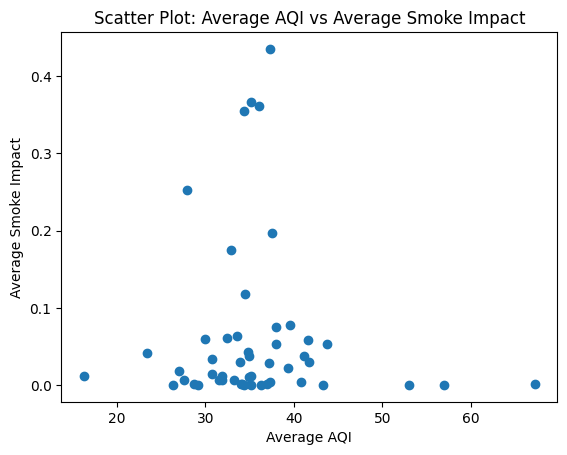

In [ ]:
plt.scatter(merged_df["avg_aqi"], merged_df["avg_smoke"])
plt.xlabel("Average AQI")
plt.ylabel("Average Smoke Impact")
plt.title("Scatter Plot: Average AQI vs Average Smoke Impact")
plt.show()


I would like to create a couple more plots to explore relations before carrying on.   
Since our AQI has negligible correlation with our estimated smoke impact, I would like to examine if there is a relationship between acres burnt and AQI. 

For this project, we would like to limit ourselves to fires which as within 650 miles of Wichita, Kansas. 

In [17]:
acres_burnt_per_year = (wildfire_df[wildfire_df["Distance"] <=  650]
                        .groupby("Year")["Acres"].sum().reset_index())
acres_burnt_filtered = acres_burnt_per_year[(acres_burnt_per_year["Year"] >= 1971) & (acres_burnt_per_year["Year"] <= 2024)]

Here, we plot total acres burnt per year, and average AQI as two separate plots on top of each other due to the difference in scales. Surprisingly, there seems to only be a weak correlation between AQI and total acres burned. This finding highly suggests that there are other factors that we are not considering, such as geographical environment (such as mountains blocking smoke), or wind direction and intensity. 

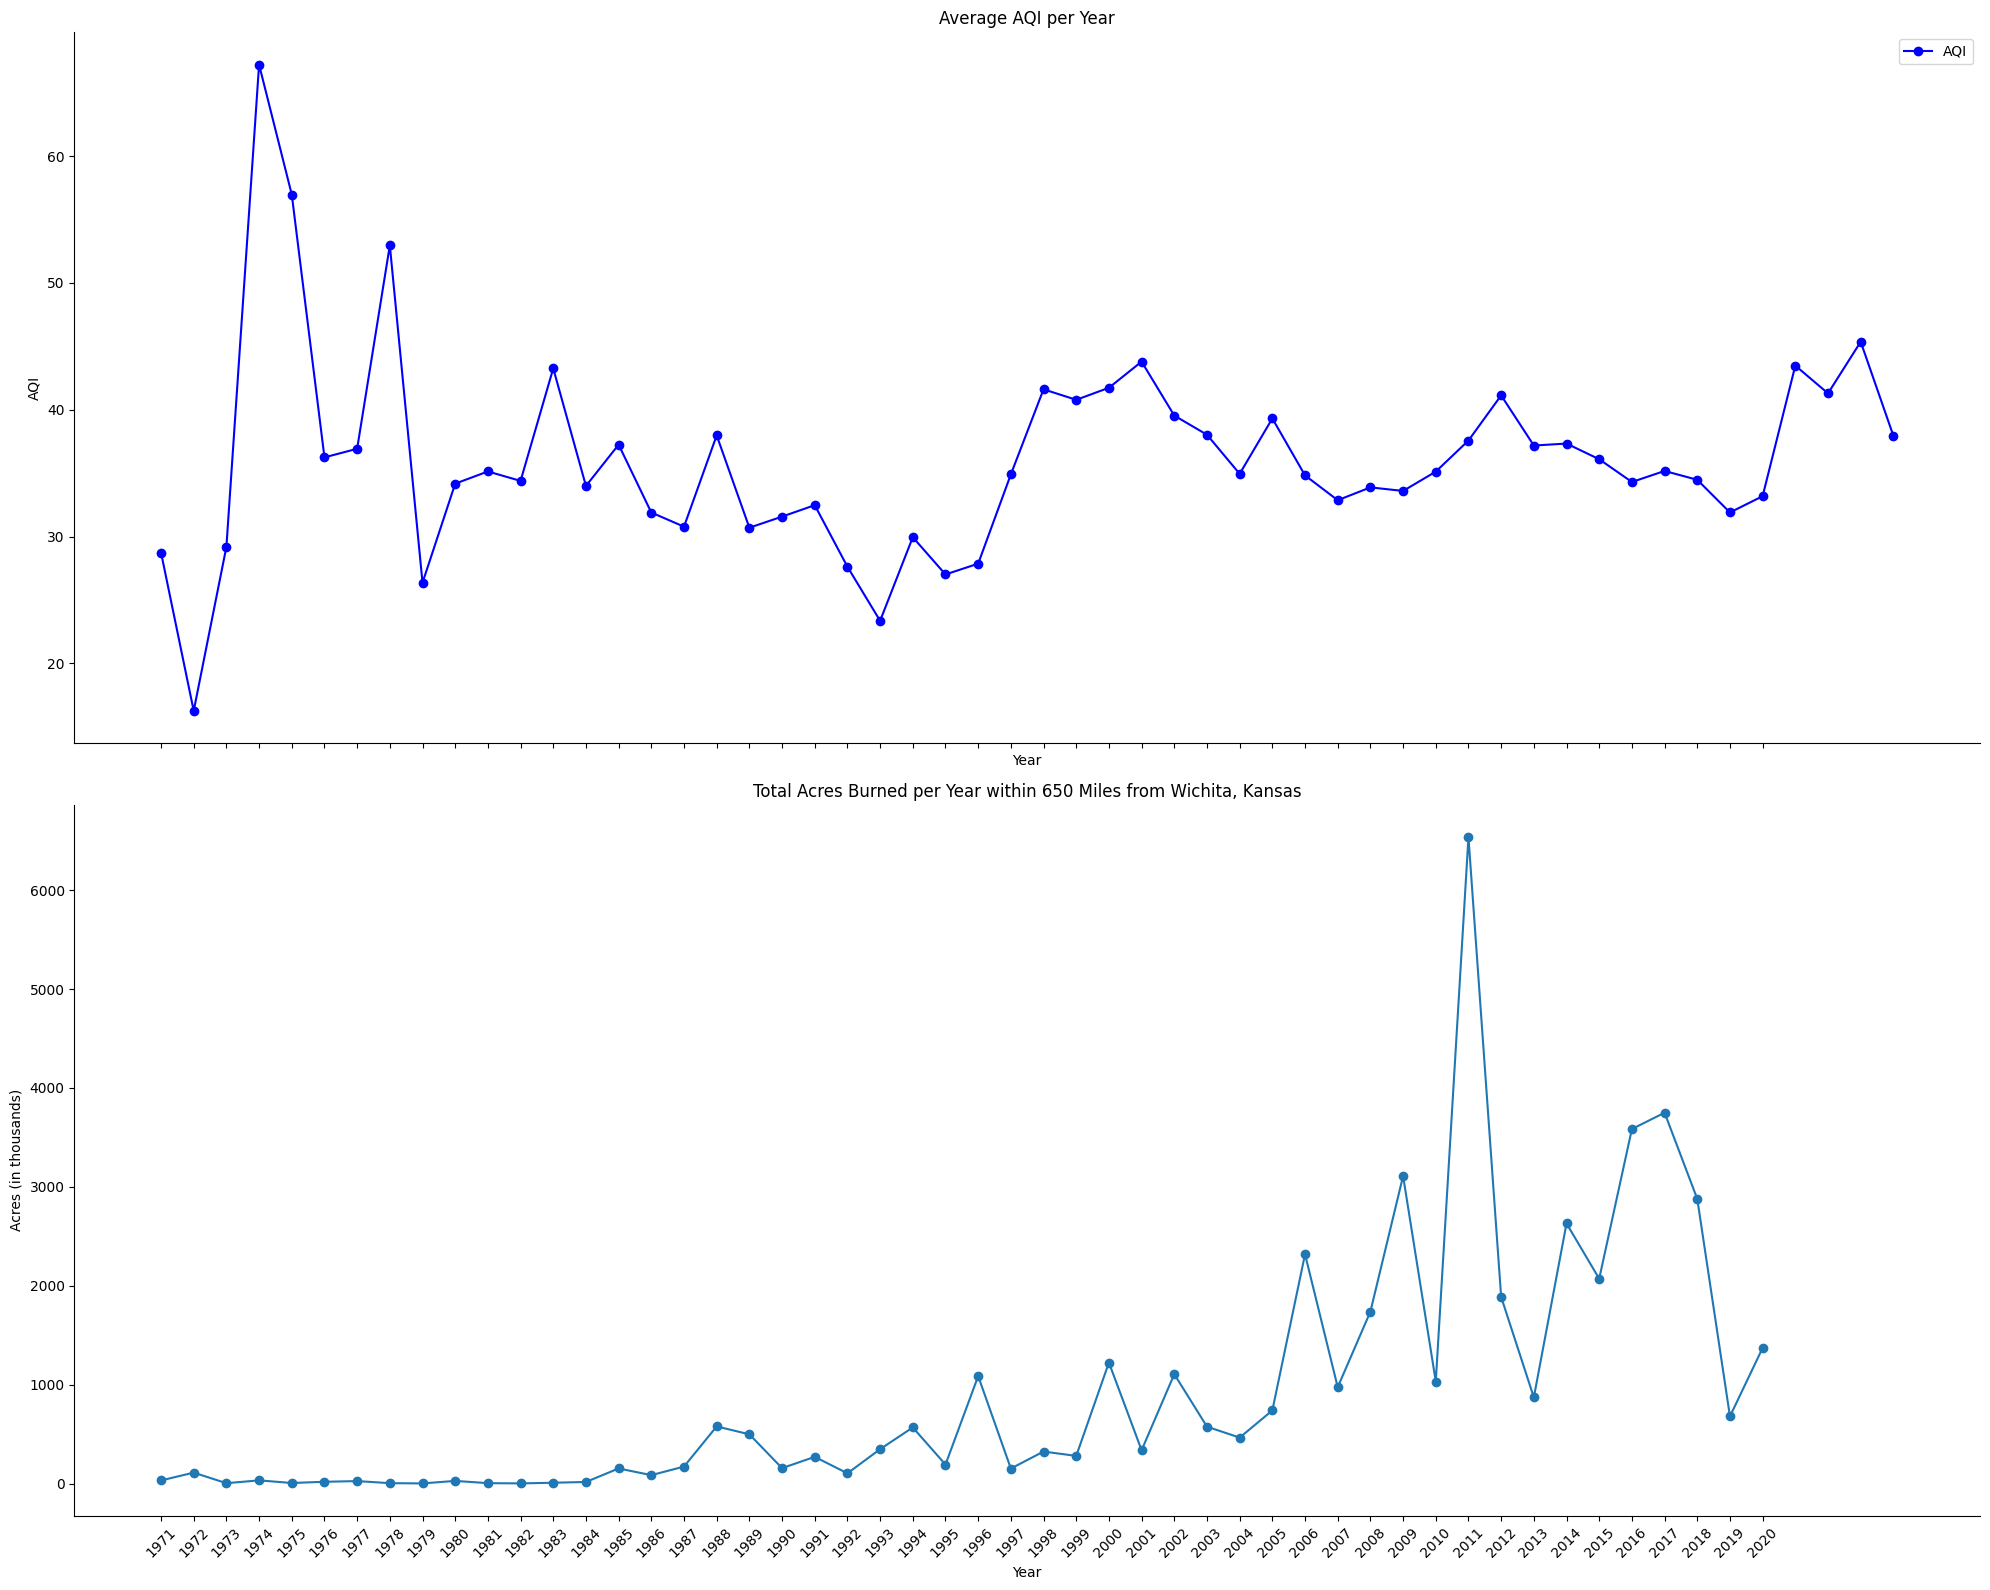

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16), sharex=True)

ax1.plot(aqi_df["Year"], aqi_df["avg_aqi"], marker="o", linestyle="-", label="AQI", color="blue")
ax1.set_title("Average AQI per Year")
ax1.set_xlabel("Year")
ax1.set_ylabel("AQI")
ax1.grid(False)
ax1.set_xticks(aqi_df["Year"])
ax1.set_xticklabels(aqi_df["Year"], rotation=45)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend()

ax2.plot(acres_burnt_filtered["Year"], acres_burnt_filtered["Acres"] / 1000, marker="o", linestyle="-")
ax2.set_title("Total Acres Burned per Year within 650 Miles from Wichita, Kansas")
ax2.set_xlabel("Year")
ax2.set_ylabel("Acres (in thousands)")
ax2.grid(False)
ax2.set_xticks(acres_burnt_filtered["Year"])
ax2.set_xticklabels(acres_burnt_filtered["Year"], rotation=45)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.tight_layout()  
plt.savefig("../graphs/aqi_and_acres_burned_per_year_p2.png")
plt.show()

I am running the code for my linear regression model again to get my predicted smoke. 

In [19]:
X = wildfire_df_model.drop(columns=["Estimated_Smoke"])
y = wildfire_df_model["Estimated_Smoke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

lin_reg_coef = lin_reg.coef_
lin_reg_intercept = lin_reg.intercept_

print("Linear Regression Coefficients (may allow negative):")
for feature, coef in zip(X_train.columns, lin_reg_coef):  
    print(f"{feature}: {coef}")
print(f"Linear Regression Intercept: {lin_reg_intercept}")
print(f"Mean Squared Error: {mse}")


Linear Regression Coefficients (may allow negative):
Year: -0.001004042459986597
Acres: 8.10024379883744e-05
Distance: -0.0008544412484807517
Fire_Weight: -0.8802468920427424
Linear Regression Intercept: 2.621978289649488
Mean Squared Error: 14.888490148426204


I wanted to explore a few models, and I started off with using a non-negative least squares (NNLS) model since we do not expect smoke to be negative.

In [21]:
X_train_with_intercept = np.hstack((np.ones((X_train.shape[0], 1)), X_train)) 
X_test_with_intercept = np.hstack((np.ones((X_test.shape[0], 1)), X_test)) 

nnls_coef, _ = nnls(X_train_with_intercept, y_train)

nnls_intercept = nnls_coef[0]
nnls_weights = nnls_coef[1:]

print("\nNNLS Coefficients (Non-Negative):")
for feature, coef in zip(X_train.columns, nnls_weights):  
    print(f"{feature}: {coef}")
print(f"NNLS Intercept: {nnls_intercept}")

y_pred_nnls = np.dot(X_test_with_intercept, nnls_coef)

nnls_mse = mean_squared_error(y_test, y_pred_nnls)
print(f"NNLS Mean Squared Error: {nnls_mse}")



NNLS Coefficients (Non-Negative):
Year: 0.0
Acres: 8.225207605365321e-05
Distance: 0.0
Fire_Weight: 0.0
NNLS Intercept: 0.0
NNLS Mean Squared Error: 14.977949811041668


Our linear regression model has a slightly better MSE than NNLS. Therefore, we will keep using that for now. 

In [22]:

y_full_pred = lin_reg.predict(X)

predictions_full_df = pd.DataFrame(X, columns=X.columns)  
predictions_full_df["Predicted_Smoke"] = y_full_pred  

predictions_full_df.reset_index(drop=True, inplace=True)

It doesn't make sense for predicted smoke to be negative. For the sake of this project, I have decided to shift prediction based on the minimum value so that it is positive but still maintains its relative scale.

In [23]:
min_value = predictions_full_df["Predicted_Smoke"].min()
if min_value < 0:
    shift_value = abs(min_value)
    predictions_full_df["Predicted_Smoke"] = predictions_full_df["Predicted_Smoke"] + shift_value

Since a linear regression model may not be the best fit for estimating smoke impact due to its inability to capture temporal patterns and non-linear relationships, I will generate sample data with added noise to evaluate how well the model can capture the underlying relationships between the variables. This will help me assess whether the model is appropriately handling the key dynamics of smoke estimation, or if a more advanced time-series model (like ARIMA or Prophet) is required to account for trends, seasonality, and noise.     
Due to climate change, we generally expect there to be more wildfires, therefore to mimic that trend, I gave a higher probablity for the wildfire fire type to be selected.

In [187]:
future_years = list(range(2025, 2051))
future_data = pd.DataFrame({"Year": future_years})

base_acres = wildfire_df_model["Acres"].mean()

increase_per_year = 175
noise_std = 200
future_data["Acres"] = [
    base_acres + (increase_per_year * i) + np.random.normal(loc=0, scale=noise_std) for i in range(len(future_years))
]

future_data["Distance"] = [wildfire_df_model["Distance"].sample(random_state=i).values[0] for i in range(len(future_years))]
fire_weight_categories = wildfire_df_model['Fire_Weight'].unique()

probabilities = [0.3, 0.2, 0.2, 0.15, 0.15]  

assert np.isclose(sum(probabilities), 1), "Probabilities should sum to 1"

future_data["Fire_Weight"] = np.random.choice(fire_weight_categories, 
                                              size=len(future_years), 
                                              p=probabilities, 
                                              replace=True)

future_data_features = future_data[["Year", "Acres", "Distance", "Fire_Weight"]]

future_predictions = lin_reg.predict(future_data_features)

future_predictions_df = future_data.copy()
future_predictions_df["Predicted_Smoke"] = future_predictions  

min_value = future_predictions_df["Predicted_Smoke"].min()

if min_value < 0:
    shift_value = abs(min_value)
    future_predictions_df["Predicted_Smoke"] = future_predictions_df["Predicted_Smoke"] + shift_value

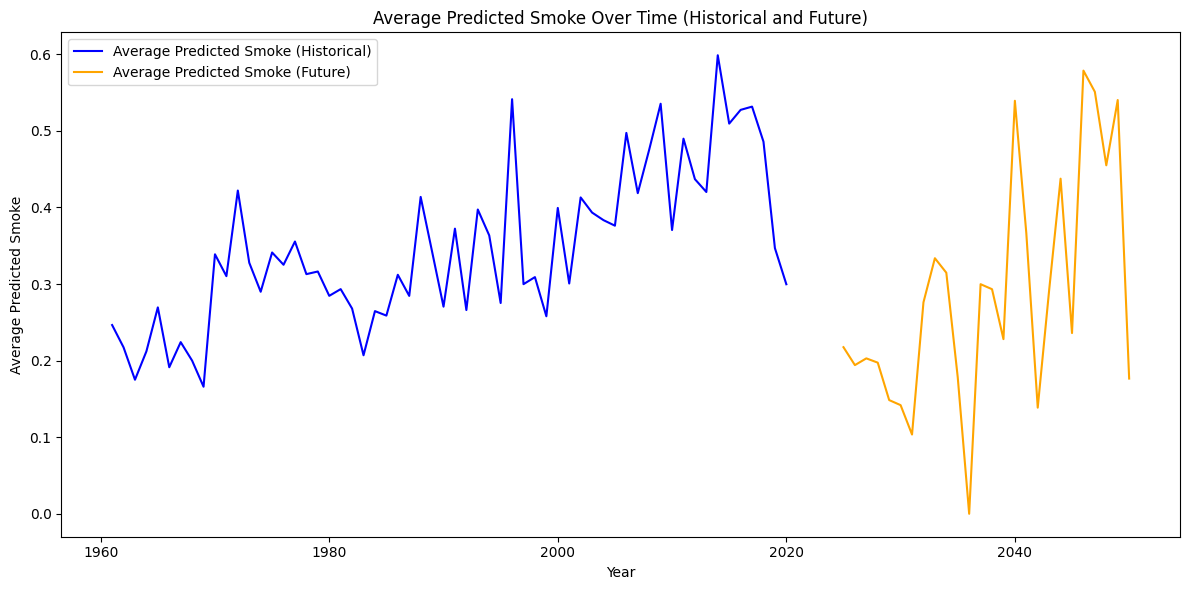

In [ ]:
historical_avg = predictions_full_df.groupby("Year")["Predicted_Smoke"].mean().reset_index()
future_avg = future_predictions_df.groupby("Year")["Predicted_Smoke"].mean().reset_index()

plt.figure(figsize=(12, 6))

plt.plot(historical_avg["Year"], historical_avg["Predicted_Smoke"], label="Average Predicted Smoke (Historical)", color="blue")
plt.plot(future_avg["Year"], future_avg["Predicted_Smoke"], label="Average Predicted Smoke (Future)", color="orange")

plt.xlabel("Year")
plt.ylabel("Average Predicted Smoke")
plt.title("Average Predicted Smoke Over Time (Historical and Future)")

plt.legend()
plt.tight_layout()
plt.show()

As we had expected, the forecasts are not reliable. Therefore, I delve deeper into forcasting by using Prophet, a time series model developed by Meta.

Based on domain knowledge on climate change, I expect the acres burnt per year to increase, therefore I predict it using a linear regression. As for distance, I expect it to be somewhat random, but based on historical trends we can have a rough idea of the regions where it's more likely to have a fire (eg: there's a huge forest 400 miles from the city). According to our histogram from part 1, considering the fires within 650 miles from the city, we can see that the data is right skewed. Therefore we apply a log-normal distribution.

In [186]:
aggregated_df = wildfire_df.groupby('Year').agg({
    'Estimated_Smoke': 'mean',  
    'Acres': 'mean',             
    'Distance': 'mean'          
}).reset_index()

df = aggregated_df.rename(columns={'Year': 'ds', 'Estimated_Smoke': 'y'})

model = Prophet()
model.add_regressor('Acres')
model.add_regressor('Distance')

model.fit(df)

X = aggregated_df['Year'].values.reshape(-1, 1) 
y_acres = aggregated_df['Acres'].values  
acres_model = LinearRegression()
acres_model.fit(X, y_acres)
future_years = np.arange(2025, 2051).reshape(-1, 1)  
future_acres = acres_model.predict(future_years)

distance_data = aggregated_df['Distance']

distance_mean = distance_data.mean()
distance_std = distance_data.std()

min_distance = distance_data.min()
if min_distance == 0:
    min_distance = distance_data[distance_data > 0].min()  
shape = distance_std / distance_mean  
scale = distance_mean 

future_distance = np.random.lognormal(mean=np.log(scale), sigma=shape, size=len(future_years))

future_dates = pd.date_range(start='2025-01-01', periods=26, freq='Y')  
future = pd.DataFrame({'ds': future_dates})

future['Acres'] = future_acres
future['Distance'] = future_distance

forecast = model.predict(future)


21:44:31 - cmdstanpy - INFO - Chain [1] start processing
21:44:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/3963293777.py:35: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_dates = pd.date_range(start='2025-01-01', periods=26, freq='Y')


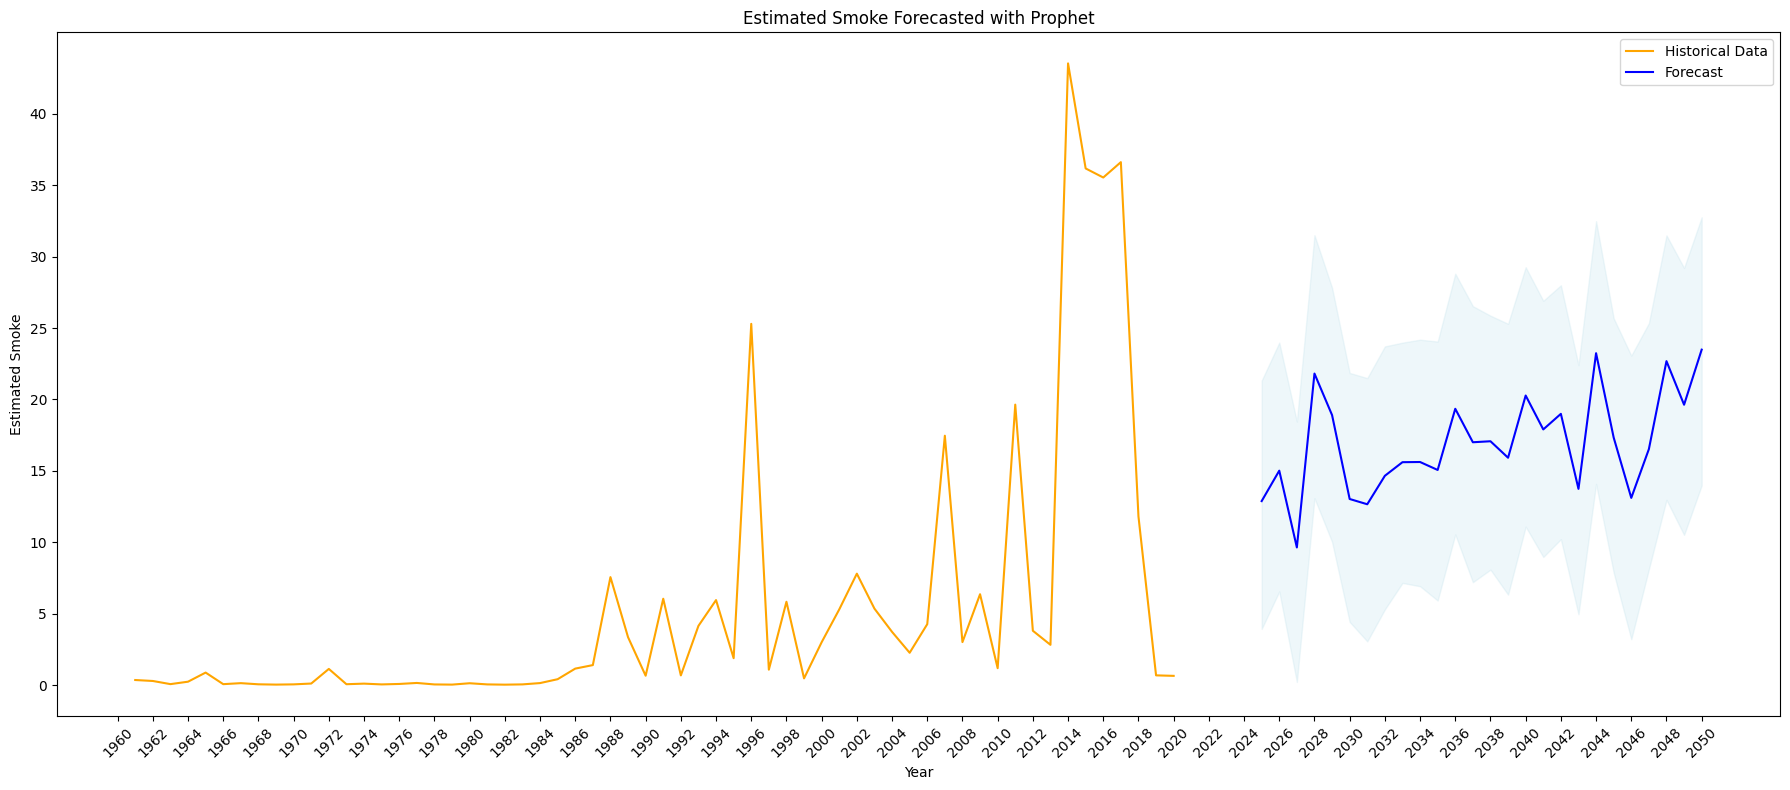

In [30]:
plt.figure(figsize=(18, 8))
plt.plot(aggregated_df['Year'], aggregated_df['Estimated_Smoke'], label='Historical Data', color='orange') 
plt.plot(forecast['ds'].dt.year, forecast['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast['ds'].dt.year, forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='#ADD8E6')
plt.title('Estimated Smoke Forecasted with Prophet')
plt.xlabel('Year')
plt.ylabel('Estimated Smoke')
plt.yticks(range(0, 45, 5))
plt.xticks(range(1960, 2051, 2), rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("../graphs/prophet_forecast")
plt.show()

The prophet model predicts general downward trend in estimated smoke levels. This suggests that, on average. the model expects smoke levels to increase over time. The shaded area around the forecasted line (blue) represents the confidence interval. We have a pretty wide interval indicating high uncertainty in the prediction. This is an interesting finding especially after we tried to incorporate the possible effects of more acres being burnt in the future due to global warming.

# Health impacts of Exposure to Wildfire

Since Kansas's economy relies heavily on agriculture and manufacturing, continuous exposure to wildfire smoke has both direct and indirect impacts. Reduced air quality affects a large percentage of the workforce, especially those involved in outdoor labor roles within agriculture. This leads to health challenges such as increased risks of respiratory issues, eye irritation, and other health problems. This jeorpardizes worker safety but also hinders producitvity. Additionally, wildfire smoke can impair crop growth by reducing sunlight leading to reduced yields. This cummunlative impact results in economic losses for farmers.       
Similarly for the manufactoring sector, in paritcular aircraft manufacturing is vulnerable to the challenges posed by degraded air quality. Indoor workers are still affected by poor outdoor air quality. Wildfire smoke particles and infiltrate manufacturing favilities and contaminate equipment and proeducts, resulting in higher risks of defects. In severe cases, operations may need to be shut down temporarily leading to lost revenue and productivity. 


Most importantly, the health impacts of exposure to continuous wildifre smoke extend beyong the workforce to affect the broader community. Airbone particles can exacerbate preexisitng conditions such as asthma and heath disease, and prolonged exposure is associated with health problems such as the increased risk of respiratory infections, cardiovascular events, and long-term lung disease. This increases the demand for healthcare services and may strain local medical resources.    
In part 2, I would like to focus on healthcare. Although it is not directly related to wildfire smoke, I am interested what are the severity of immediate effects such as injuries or deaths due to wildfire. On top of that, I would like to examine some long-term health issues such as risks for cancer, asthma, or respiratory-releated diseases.    
Understanding health implications is crucial as protecting community health is fundamental to maintaining Kansas's workforce and economy. By analyzing the effect of smoke impact on health, we can come up with strategies to better prioritize health protection and possible preventions. 


The first dataset I would like to examine comes from the [U.S. Fire Administration](https://www.usfa.fema.gov/statistics/deaths-injuries/states.html). There were multiple datasets available on the website, such as fire loss, fire death and injury rates, and firefighter fatalities. The dataset that I thought was intesting was the [Fire death and injury rates (2013-2022)](https://www.usfa.fema.gov/statistics/data-sets/) dataset. 
The description on the website said there are 9 worksheets representing statistics for U.S. states and various population groups on fire death/ injury rates and relative risk of dying in a fire.     
Even though this dataset is not specific to Kansas, I thought it would be interesting to study. 

In [ ]:
fire_death_injury =  pd.read_excel("../data/death-injury-data-sets-2022.xlsx","State Deaths, Rate, Risk 2022", header = 2)
# Rows after this are just notes so we can ignore. 
fire_death_injury = fire_death_injury[0:52]

Upon investigating the dataset, I noticed that it only contains data for 2022. This limits the analysis of trends over time, which are crucial for understanding the evolving impact of wildfire smoke. Additionally, the dataset does not label the specific types of fires, meaning deaths and injuries could have resulted from structural fires, accidents, or other causes unrelated to wildfires.

After further consideration, I believe it would not be appropriate to conclude that the deaths and injuries are related to wildfire smoke. However, it could provide a useful snapshot for comparing fire-related deaths between states, offering some context for how Kansas fares relative to other states in 2022.

In [32]:
fire_death_injury[45:50]

,State,Fire Deaths (2022),Fire Death Rate Per Million Population (2022),Relative Risk of Fire Death (2022)
45,Vermont**,13,20.1,1.5
46,Virginia,108,12.4,0.9
47,Washington,96,12.3,0.9
48,West Virginia,41,23.1,1.7
49,Wisconsin,73,12.4,0.9


States with labeled with one aestrick (*) has less than 10 deaths, and are not recorded in this dataset. States labeled with two aestricks (**) denote that fire deaath rates should be used with caution due to small numbers of death ( <20 deaths as determined by the National Center for Health Statistics.)


/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/121271505.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fire_death_injury["Fire Deaths (2022)"] = fire_death_injury["Fire Deaths (2022)"].replace('*', 0)


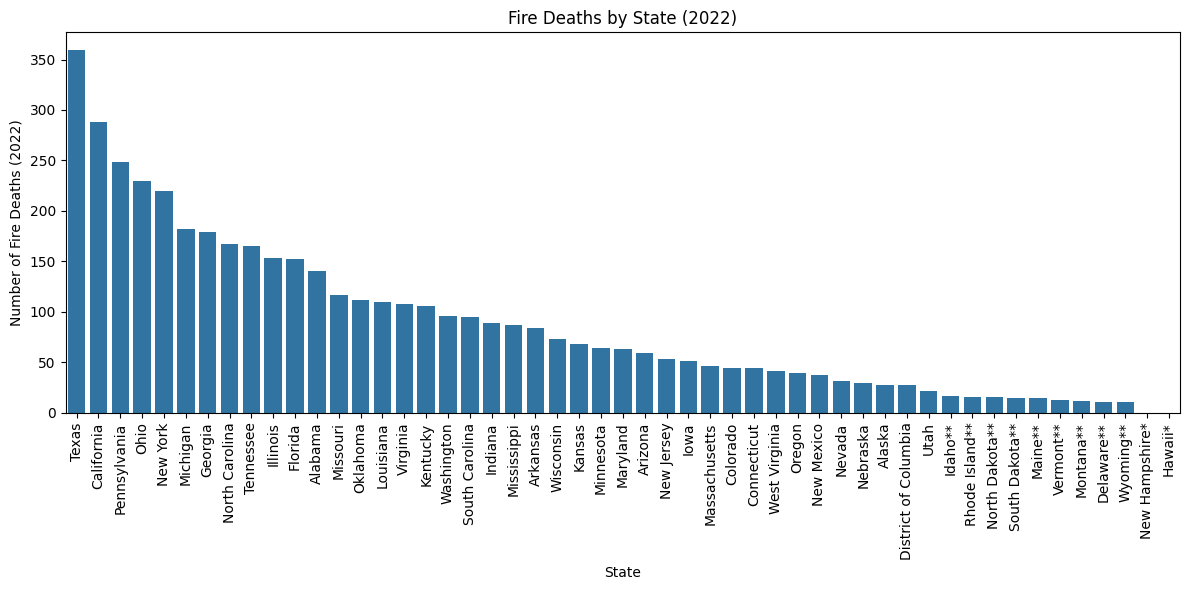

In [33]:
# Replace '*' with 0 in the 'Fire Deaths (2022)' column since we do not know the exact numbers. 
fire_death_injury["Fire Deaths (2022)"] = fire_death_injury["Fire Deaths (2022)"].replace('*', 0)

fire_death_injury["Fire Deaths (2022)"] = pd.to_numeric(fire_death_injury["Fire Deaths (2022)"])

filtered_data_injury = fire_death_injury[fire_death_injury["State"] != "United States"]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="State",
    y="Fire Deaths (2022)",
    data=filtered_data_injury.sort_values("Fire Deaths (2022)", ascending=False)
)

plt.xticks(rotation=90) 
plt.title("Fire Deaths by State (2022)")
plt.xlabel("State")
plt.ylabel("Number of Fire Deaths (2022)")
plt.tight_layout()

plt.show()

Looking at the dataset, I believed that the fire deaths decreased for states will less land area (ie: less wildfire). Therefore I wanted to test out my assumption. I used the table scrapped from the Wikipedia page which contains information for each state and their respective total area (sq mi and km2), land area (sq mi and km2) and water area (Sq mi, km2, area %)

In [34]:
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area"

response = requests.get(url)

tables = pd.read_html(response.text)

state_size_table = tables[0]

if isinstance(state_size_table.columns, pd.MultiIndex):
    state_size_table.columns = [' '.join(col).strip() for col in state_size_table.columns.values]

state_size_table.to_excel("../data/state_size_data.xlsx", index=False)

/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/1680457331.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [35]:
state_size_table.head(3)

,State / territory State / territory,Total area sq mi,Total area km2,Land area sq mi,Land area km2,Water area sq mi,Water area km2,Water area %
0,Alaska,665384,1723337,570641,1477953,94743,245383,14.2%
1,Texas,268596,695662,261232,676587,7365,19075,2.7%
2,California,163695,423967,155779,403466,7916,20501,4.8%


Reviewing the data, I believe that land area will be the most relevant to wildfire. Therefore, I kept the State and land area in sq mi columns. Next, I remove the regions which are a combination (eg: 50 states and DC) instead if being a single state. I noticed that the data includes territory, but we will remove that by using a inner join with our fire death data.  

In [36]:
filtered_state_size_table = state_size_table.iloc[:, [0, 3]]
filtered_state_size_table.columns = ["State", "Land Area sq mi"]
filtered_state_size_table = filtered_state_size_table[
    ~filtered_state_size_table["State"].isin(["United States", "50 States and DC", "Contiguous US", "50 States"])
]

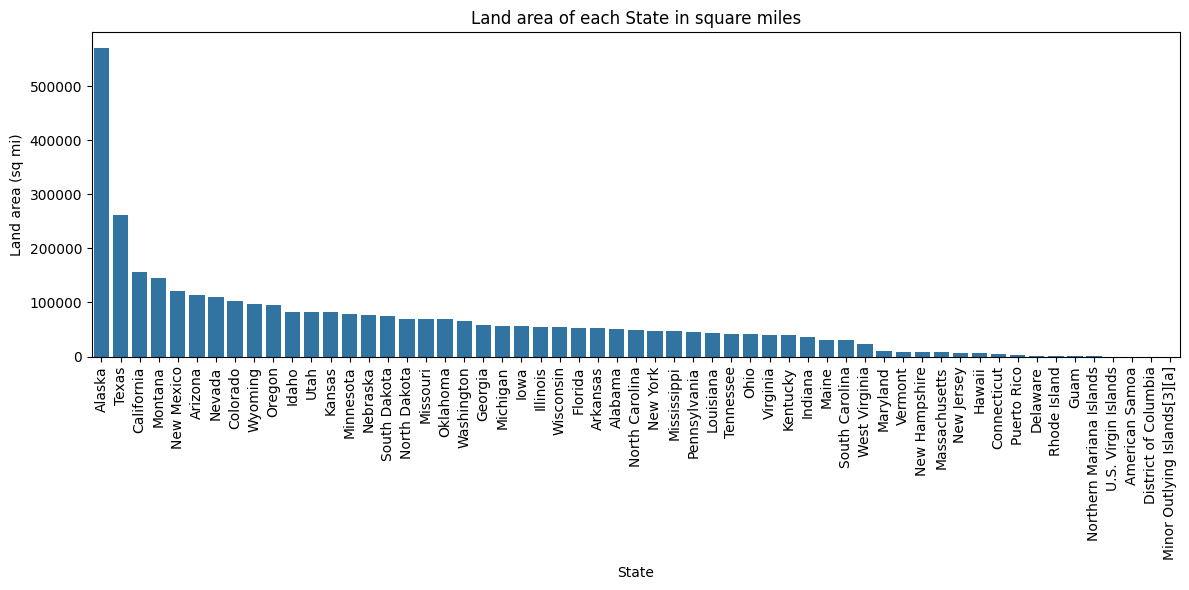

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x="State",
    y="Land Area sq mi",
    data=filtered_state_size_table.sort_values("Land Area sq mi", ascending=False)
)

plt.xticks(rotation=90)  
plt.title("Land area of each State in square miles")
plt.xlabel("State")
plt.ylabel("Land area (sq mi)")
plt.tight_layout()

plt.show()

Next, we clean the data from the fire death data to prepare it to merge with the land area data.

In [38]:
filtered_data_injury.loc[:, "State"] = filtered_data_injury["State"].str.replace(r'\*+', '', regex=True)

In [39]:
merged_size_injury = pd.merge(
    filtered_state_size_table, 
    filtered_data_injury, 
    on="State", 
    how="inner"  
)
merged_size_injury.head(5)

,State,Land Area sq mi,Fire Deaths (2022),Fire Death Rate Per Million Population (2022),Relative Risk of Fire Death (2022)
0,Alaska,570641,27,36.8,2.8
1,Texas,261232,359,12,0.9
2,California,155779,288,7.4,0.6
3,Montana,145546,12,10.7,0.8
4,New Mexico,121298,37,17.5,1.3


In [40]:
simplified_size_injury = merged_size_injury[["State", "Land Area sq mi", "Fire Deaths (2022)"]]

Correlation between Land Area and Fire Deaths: 0.12


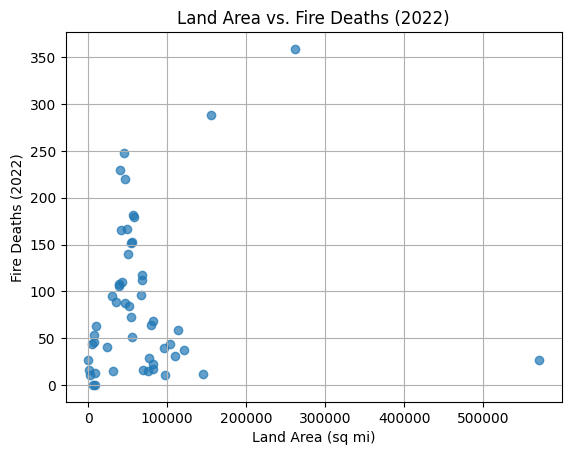

In [41]:
correlation = simplified_size_injury["Land Area sq mi"].corr(simplified_size_injury["Fire Deaths (2022)"])

print(f"Correlation between Land Area and Fire Deaths: {correlation:.2f}")

plt.scatter(simplified_size_injury["Land Area sq mi"], simplified_size_injury["Fire Deaths (2022)"], alpha=0.7)
plt.title("Land Area vs. Fire Deaths (2022)")
plt.xlabel("Land Area (sq mi)")
plt.ylabel("Fire Deaths (2022)")
plt.grid(True)
plt.show()

Very weak positive correlation, suggesting that variation in land area do not appear to have a signifcant effect on the number of fire deaths. However, this indicates that there is a slight tendency for larger land areas to have slightly higher fire deaths, but relationship is too weak to be meaningful for prediction or cause-and-effection conclusions. 


## Asthma

While our limited data prevents us from fully exploring the relationship between wildfires and related fatalities or injuries, there are other significant health concerns that we can address.       
According to [CDC](https://www.cdc.gov/wildfires/risk-factors/index.html#:~:text=Wildfire%20smoke%20can%20make%20you%20sick.&text=Coughing,Asthma%20attacks), wildfire smoke can lead to immediate health effects such as coughing, difficulty breathing, and asthma attacks. Additionally, studies have shown that prolonged exposure to wildfire smoke can contribute to the development of asthma in children. 

The following data is retrived from the [EPHT data explorer](https://maps.kdhe.state.ks.us/ksepht/?ContentAreaID=3&GeoLayer=2&IndicatorID=90&MeasureID=437&StratFieldName=None&StratLocalId=None&Year=2019&page=Home). The asthma data is available from 2009 to 2019 on a county level for Kansas. Wichita is in Sedgwick county, and I thouught it would be interesting to compare if the number of emergency department visits for asthma is greater than the other counties, and if there is a correlation with wildfire smoke.    

In [ ]:
asthma_df = pd.read_csv("../data/epht_asthma.csv")
asthma_df.head(3)

,ContentArea,Indicator,Measure,Year,Geography,County,GeoID,Filter,FilterValue,Value,Version
0,Asthma,Emergency department visits for asthma,Number of emergency department visits for asthma,2009,County,Allen,20001,NaN,NaN,22,030904340220090000010100
1,Asthma,Emergency department visits for asthma,Number of emergency department visits for asthma,2009,County,Anderson,20003,NaN,NaN,79,030904340220090000010100
2,Asthma,Emergency department visits for asthma,Number of emergency department visits for asthma,2009,County,Atchison,20005,NaN,NaN,92,030904340220090000010100


The columns of interest in this dataset are Year, County, and Value, which represents the number of emergency department visits for asthma. However, for some counties and years, the data may be unstable, suppressed, or have no recorded events. For the purpose of this project, I will replace these values with NaN. Additionally, we need to clean columns containing commas, as they are not recognized as numerical values.

In [ ]:
asthma_subset = asthma_df[["Year","County","Value"]]
asthma_subset.head(3)

,Year,County,Value
0,2009,Allen,22
1,2009,Anderson,79
2,2009,Atchison,92


In [44]:
asthma_subset.loc[:, "Value"] = asthma_subset["Value"].astype(str).str.replace(',', '', regex=False).str.strip()

asthma_subset.loc[:, "Value"] = pd.to_numeric(asthma_subset["Value"], errors="coerce")

Since Kansas has 105 counties, plotting all of them in a single 2D time series graph would be impractical. Therefore, I am filtering the dataset to include only the surrounding counties, specifically those within a 2-county radius.

In [45]:
county_list = ["Sedgwick", "Harvey", "Reno", "Kingman", "Harper", "Sumner", "Cowley", \
               "Butler", "Marion", "McPherson", "Rice", " Stafford", "Pratt", "Barber", \
               "Chautauqua", "Elk", "Greenwood", "Chase"]
filtered_asthma = asthma_subset[asthma_subset["County"].isin(county_list)]

We pivot the data to make it easy for plotting purposes.

In [46]:
pivoted_data = filtered_asthma.pivot(index="Year", columns="County", values="Value")

/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/398667473.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


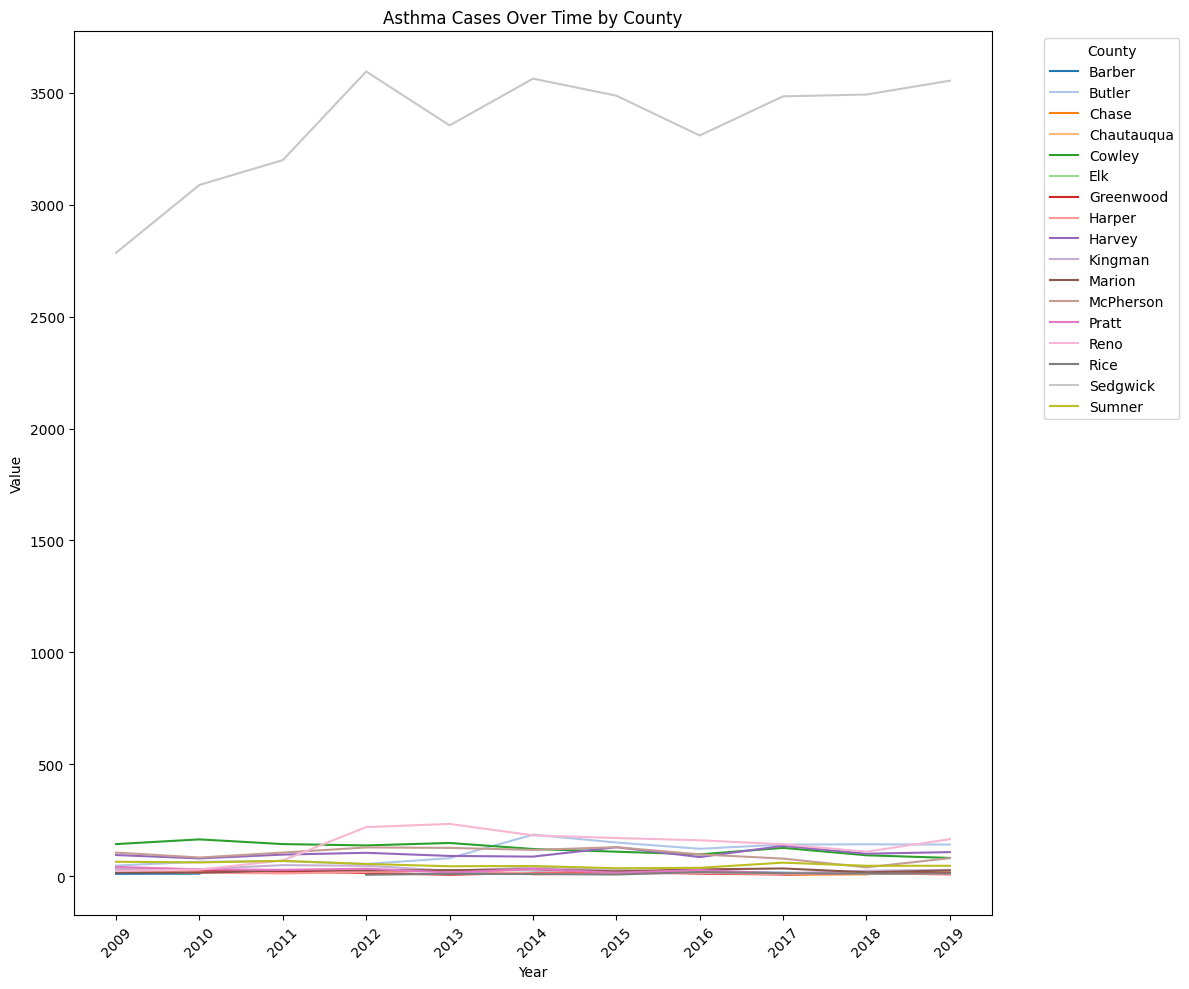

In [47]:
cmap = get_cmap("tab20") 
colors = {county: cmap(i) for i, county in enumerate(pivoted_data.columns)}

plt.figure(figsize=(12, 10))
for county in pivoted_data.columns:
    plt.plot(pivoted_data.index, pivoted_data[county], label=county, color=colors[county])

plt.xticks(ticks=pivoted_data.index, labels=pivoted_data.index, rotation=45)

plt.title("Asthma Cases Over Time by County")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend(title="County", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

My hypotheses was that Segwick county will have the highest rate of asthma due to Wichita being in Segwick, and it being the largest city in Kansas.        
The results of this graph aligns with my hypothesis. However, the vast difference in the number of patients visiting the emergency department in Sedgwick County compared to other counties is concerning. While there could be multiple contributing factors, this analysis specifically explores whether exposure to wildfire smoke may be a significant cause.       
Upon inspecting the surrounding counties individually, I observed that Reno, Harvey, and Butler counties, in particular, also experienced noticeably higher emergency department visits. If the number of asthma-related visits is indeed linked to exposure to wildfire smoke, these neighboring counties should also consider implementing similar precautionary measures.

Now, focusing specifically on Segwick county where Wichita resides, I am investigating if there is a strong correlation between the number of visits due to asthma, and smoke.

/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/659319195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asthma_sedgwick["Year"] = pd.to_numeric(asthma_sedgwick["Year"], errors="coerce")


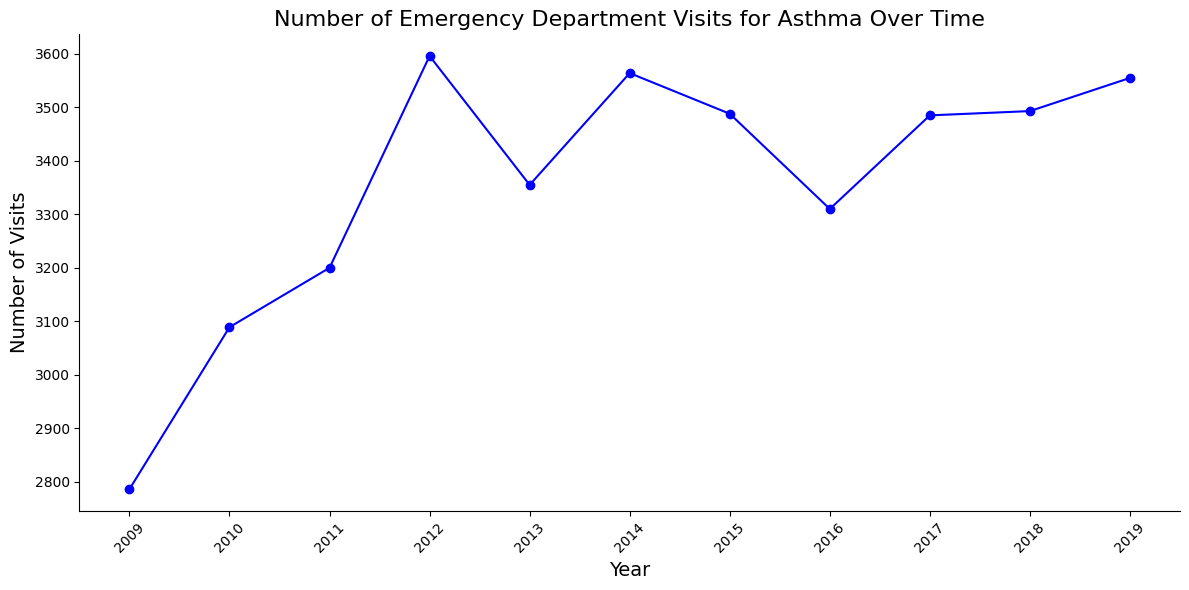

In [48]:
asthma_sedgwick = asthma_subset[asthma_subset["County"] == "Sedgwick"]
asthma_sedgwick["Year"] = pd.to_numeric(asthma_sedgwick["Year"], errors="coerce")

plt.figure(figsize=(12, 6))
plt.plot(asthma_sedgwick["Year"], asthma_sedgwick["Value"], marker="o", linestyle="-", color="blue")

plt.title("Number of Emergency Department Visits for Asthma Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Visits", fontsize=14)

unique_years = sorted(asthma_sedgwick["Year"].dropna().unique())  
plt.xticks(unique_years, rotation=45) 

plt.grid(False)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("../graphs/num_visit_asthma_over_time.png")
plt.show()


I thought it would be interesting to observe plot the acres burnt per year, and compare it with the number of visits due to asthma per year.

/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/1476510540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acres_burnt_subset["Year"] = pd.to_numeric(acres_burnt_subset["Year"], errors="coerce")


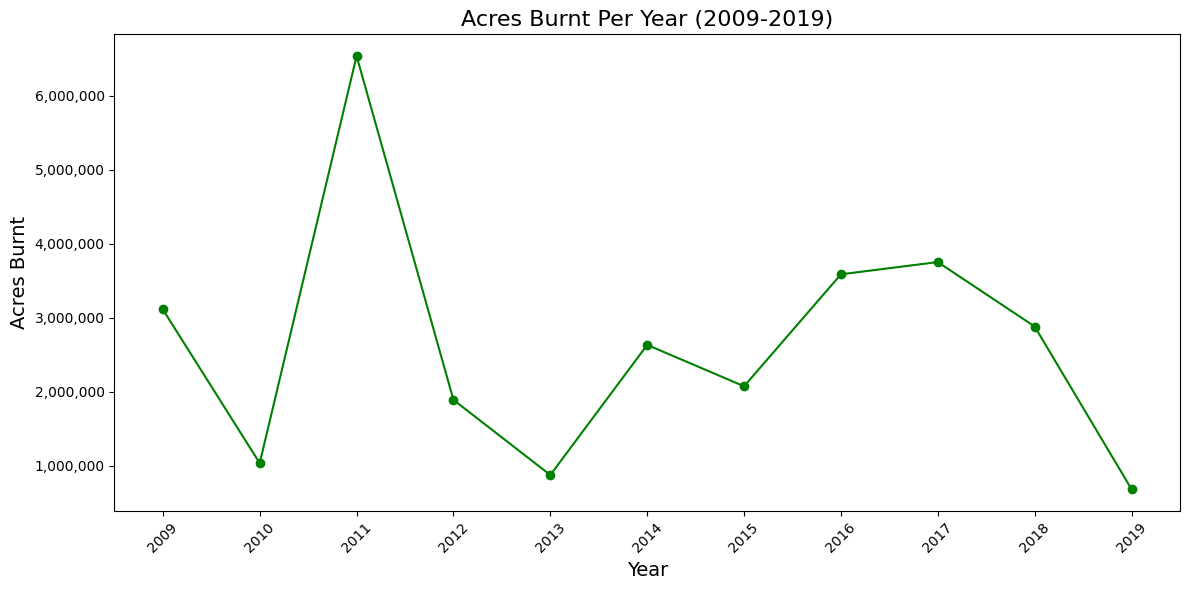

In [49]:
acres_burnt_subset = acres_burnt_per_year[(acres_burnt_per_year["Year"] >= 2009) & (acres_burnt_per_year["Year"] <= 2019)]
acres_burnt_subset["Year"] = pd.to_numeric(acres_burnt_subset["Year"], errors="coerce")

plt.figure(figsize=(12, 6))
plt.plot(acres_burnt_subset["Year"], acres_burnt_subset["Acres"], marker="o", linestyle="-", color="green")

plt.title("Acres Burnt Per Year (2009-2019)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Acres Burnt", fontsize=14)

unique_years = sorted(acres_burnt_subset["Year"].dropna().unique())
plt.xticks(unique_years, rotation=45)

plt.grid(False)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

We observe a similar pattern in both graphs, where an increase in acres burnt corresponds to a rise in emergency department visits for asthma. However, after 2017, this trend seems to change. It's possible that there was a correlation between the two, and local health departments may have implemented preventive measures to mitigate the situation.

Next, I would like to explore the correlation between the number of visits for asthma, and smoke.   
I started off by merging the asthma data with the wildfire data, and computing a correlation matrix between the number of emergency department visits for asthma, acres burnt, estimated smoke, and distance.

In [153]:
merged_df = pd.merge(asthma_sedgwick, wildfire_df, on='Year')
merged_df.head(3)

,Year,County,Value,Acres,Distance,Fire_Type,Fire_Weight,Estimated_Smoke
0,2009,Sedgwick,2786.0,55405.813453,462.881332,Wildfire,0.4,25.859255
1,2009,Sedgwick,2786.0,30875.452667,482.492736,Wildfire,0.4,13.262695
2,2009,Sedgwick,2786.0,29975.695332,554.139823,Wildfire,0.4,9.761814


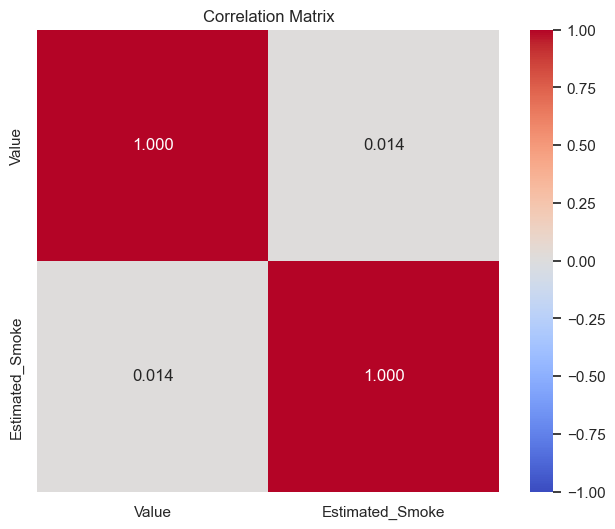

In [156]:
correlation_matrix = merged_df[["Value", "Estimated_Smoke"]].corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".3f", vmin=-1, vmax=1, square=True)

plt.title("Correlation Matrix")
plt.show()

The numbers were quite low, and I suspected this might be due to the asthma-related data being in yearly granularity. Therefore, I decided to repeat the same steps using my aggregated dataset, which contains the average estimated smoke, acres, and distance per year.

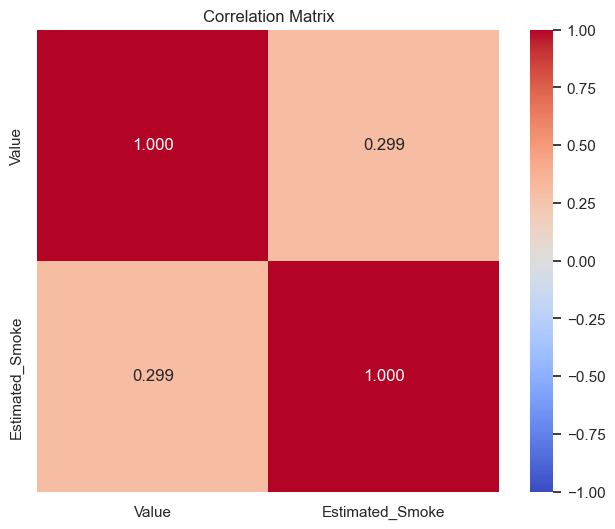

In [157]:
merged_df2 = pd.merge(asthma_sedgwick, aggregated_df, on="Year")

correlation_matrix2 = merged_df2[["Value", "Estimated_Smoke"]].corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix2, annot=True, cmap="coolwarm", fmt=".3f", vmin=-1, vmax=1, square=True)

plt.title("Correlation Matrix")
plt.show()

The correlation analysis reveals that, after averaging the data per year, a stronger relationship emerges between estimated smoke exposure and asthma-related emergency visits. Specifically, the correlation between Estimated_Smoke and Acres increases significantly, suggesting that higher smoke correlate more strongly with increased asthma visits. Additionally, the negative correlation between Estimated_Smoke and Distance becomes more pronounced, indicating that greater distances from wildfires are associated with lower smoke exposure. Overall, aggregating the data by year helps to reveal more meaningful trends, showing that wildfires have a notable impact on public health, particularly in relation to asthma exacerbations.

There is very limited data available (only 10 years), but I was still curious about the predictions that can be made. I had three approaches, the first approach in the next cell does not contain an aggregate of the estimated smoke in a year. There are multiple entries a year, which may allow us to capture fine-grained details about the relationship between smoke levels and asthma visits.

16:06:30 - cmdstanpy - INFO - Chain [1] start processing
16:06:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/103123576.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start="2025-01-01", periods=26, freq="Y")


<Figure size 1200x600 with 0 Axes>

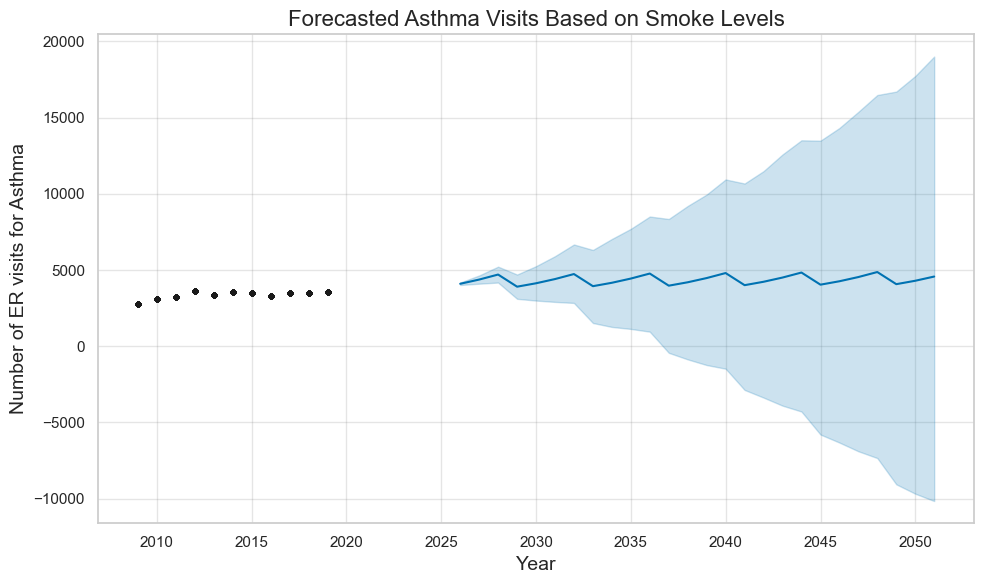

In [182]:
df = merged_df[["Year", "Value", "Estimated_Smoke"]].rename(columns={"Year": "ds", "Value": "y"})

model = Prophet()

model.add_regressor("Estimated_Smoke")

model.fit(df)

future_years = pd.date_range(start="2025-01-01", periods=26, freq="Y")  
future = pd.DataFrame({"ds": future_years})
future["Estimated_Smoke"] = forecast["yhat"].values 

forecast = model.predict(future)

plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title("Forecasted Asthma Visits Based on Smoke Levels", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of ER visits for Asthma", fontsize=14)
plt.tight_layout()
plt.show()


The graph implies that we expect the number of ER visits for asthma in future years to increase. As we had predicted smoke to increase yearly, this implies that as wildfire smoke levels increase, the number of patients visiting the emergency department due to asthma increases. However, likely due to the limited data, the uncertainties increase significantly every year. At the same time, there may be other factors that could influence asthma rates that the model did not consider. 


The second approach uses the average of estimated smoke for each year. This method reduces noise in the data, leading to more stable and reliable forecasts. It is also appropriate given that asthma data is available only at a yearly granularity, ensuring consistency between the smoke and asthma datasets.

02:47:29 - cmdstanpy - INFO - Chain [1] start processing
02:47:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/3762044129.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start="2025-01-01", periods=26, freq="Y")


<Figure size 1200x600 with 0 Axes>

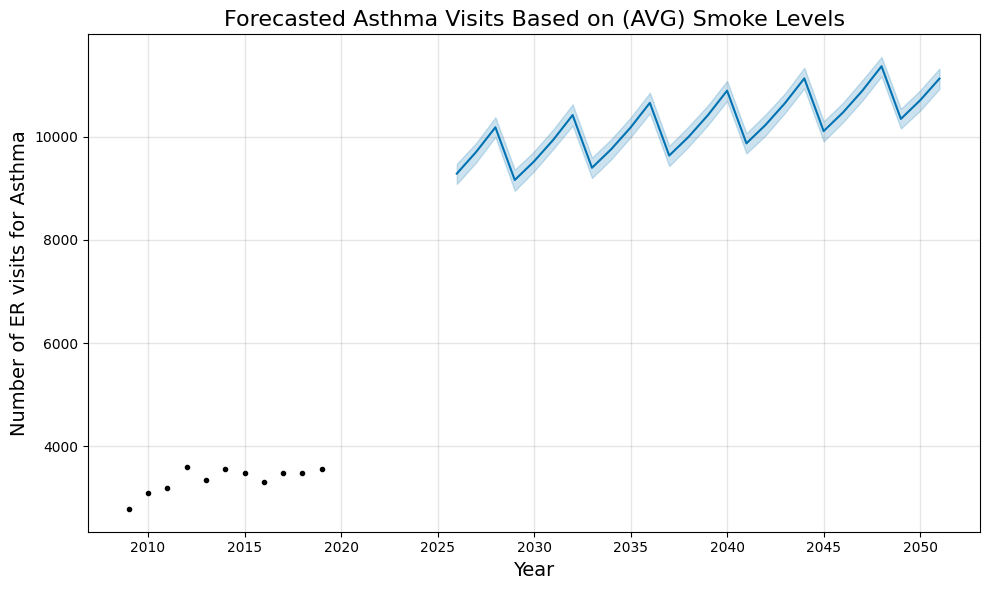

In [54]:
df_grouped = merged_df.groupby("Year").agg({
    "Estimated_Smoke": "mean",
    "Value": "first"
}).reset_index()

df = df_grouped[["Year", "Value", "Estimated_Smoke"]].rename(columns={"Year": "ds", "Value": "y"})

model = Prophet()

model.add_regressor("Estimated_Smoke")

model.fit(df)

future_years = pd.date_range(start="2025-01-01", periods=26, freq="Y")  
future = pd.DataFrame({"ds": future_years})
future["Estimated_Smoke"] = forecast["yhat"].values 

forecast = model.predict(future)

plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title("Forecasted Asthma Visits Based on (AVG) Smoke Levels", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of ER visits for Asthma", fontsize=14)
plt.tight_layout()
plt.show()


Using the average predicted smoke per year decreases the uncertainty around the forecast, leading to a more confident prediction of increased asthma-related ER visits. However, the high uncertainty in the predicted smoke levels themselves could limit the accuracy of this forecast.

The last approach involves using the sum of estimated smoke in a year, rather than using an average value. This approach can capture the cumulative impact of smoke exposure over the entire year, potentially providing a more accurate representation of the relationship between smoke and asthma. I believe that this approach will be able to provide the most accurate representation of the relationship between smoke and asthma due to the format of our asthma data.

02:47:29 - cmdstanpy - INFO - Chain [1] start processing
02:47:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/1546754089.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start="2025-01-01", periods=26, freq="Y")


<Figure size 1200x600 with 0 Axes>

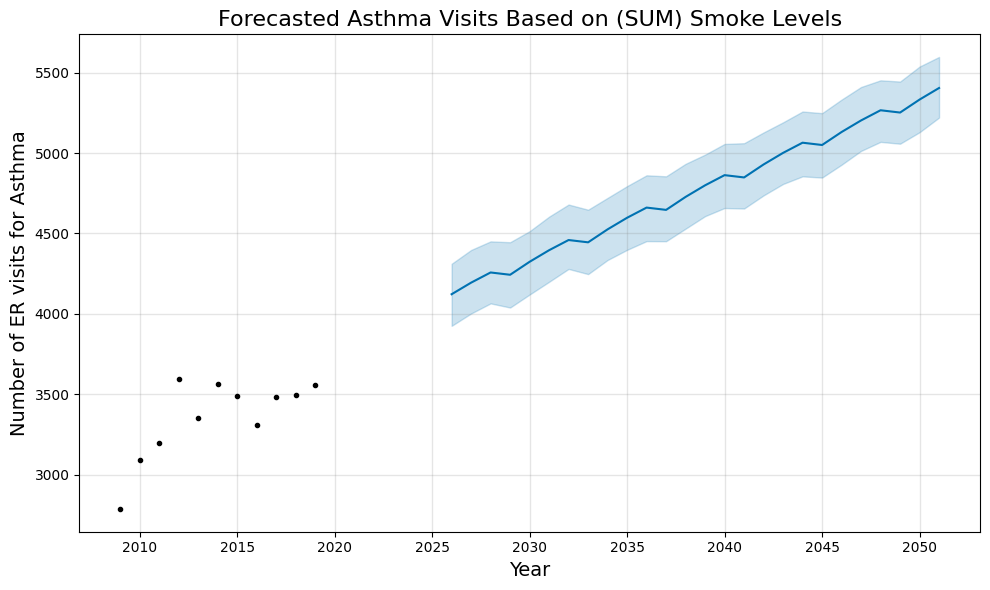

In [55]:
df_grouped = merged_df.groupby("Year").agg({
    "Estimated_Smoke": "sum",
    "Value": "first"
}).reset_index()

df = df_grouped[["Year", "Value", "Estimated_Smoke"]].rename(columns={"Year": "ds", "Value": "y"})

model = Prophet()

model.add_regressor("Estimated_Smoke")

model.fit(df)

future_years = pd.date_range(start="2025-01-01", periods=26, freq="Y")  
future = pd.DataFrame({"ds": future_years})
future["Estimated_Smoke"] = forecast["yhat"].values 

forecast = model.predict(future)

plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title("Forecasted Asthma Visits Based on (SUM) Smoke Levels", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of ER visits for Asthma", fontsize=14)
plt.tight_layout()
plt.show()


While this approach also predicts an increasing trend in asthma-related visits, it's a more pronounced upward trend suggesting a potentially stronger relationship between smoke levels and asthma. However, the wider confidence intervals highlight the potential for greater variability in the actual impact.

To improve the precision of our forecasts, we would need to incorporate more data, either by extending the time period or by using finer granularity (e.g., monthly data instead of yearly). Additionally, including other relevant factors, such as temperature, humidity, and air quality index (AQI), would help enhance the accuracy of the predictions.

## Cancer

Another health concern that has been associated with exposure to wildfire smoke is cancer. Wildfire smoke contains harmful pollutants such as particulate matter (PM2.5), carbon monoxide, and polycyclic aromatic hydrocarbons (PAHs), all of which have been linked to various forms of cancer. These pollutants, which are present in the smoke from burning vegetation and other organic matter, can have long-term detrimental effects on human health. While wildfire smoke is associated with multiple types of cancer, this project will focus on two major categories: lung cancer and respiratory system cancers.

The following data is retrieved from the [CDC](https://wonder.cdc.gov/cancer-v2021.HTML). However, unlike the asthma dataset, the cancer dataset is available on a state granuality. Therefore, might lead to skewed generalized conclusiosn.          
We manually reviewed the file and set skipfooter=55 to remove all rows with notes that are not part of the main dataset.

In [119]:
cancer = pd.read_csv("../data/cdc_cancer_statistics.txt", sep="\t", quotechar='"', skipfooter=55, engine="python")
cancer.head(3)

,Notes,Cancer Sites,Cancer Sites Code,States,States Code,Year,Year Code,Count,Population,Age-Adjusted Rate,Crude Rate
0,NaN,All Invasive Cancer Sites Combined,0,Kansas,20,1999,1999,12726,2678338,470.2,475.1
1,NaN,All Invasive Cancer Sites Combined,0,Kansas,20,2000,2000,12812,2693681,470.4,475.6
2,NaN,All Invasive Cancer Sites Combined,0,Kansas,20,2001,2001,12815,2702162,467.0,474.2


There are 105 cancer types, we will filter the dataset to contain the following cancers:    
1. Nose, Nasal Cavity and Middle Ear
2. Larynx
3. Lung and Bronchus
4. Respiratory System 
      
After reviewing the data, I have dropped Pleura from the analysis as for most of years, data is either 0.0 or surpressed.

In [139]:
unique_cancers = cancer["Cancer Sites"].unique()
print(len(unique_cancers))
print(unique_cancers)      

105
['All Invasive Cancer Sites Combined' 'Oral Cavity and Pharynx' 'Lip'
 'Tongue' 'Salivary Gland' 'Floor of Mouth' 'Gum and Other Mouth'
 'Nasopharynx' 'Tonsil' 'Oropharynx' 'Hypopharynx'
 'Other Oral Cavity and Pharynx' 'Digestive System' 'Esophagus' 'Stomach'
 'Small Intestine' 'Colon and Rectum' 'Colon excluding Rectum' 'Cecum'
 'Appendix' 'Ascending Colon' 'Hepatic Flexure' 'Transverse Colon'
 'Splenic Flexure' 'Descending Colon' 'Sigmoid Colon'
 'Large Intestine, NOS' 'Rectum and Rectosigmoid Junction'
 'Rectosigmoid Junction' 'Rectum' 'Anus, Anal Canal and Anorectum'
 'Liver and Intrahepatic Bile Duct' 'Liver' 'Intrahepatic Bile Duct'
 'Gallbladder' 'Other Biliary' 'Pancreas' 'Retroperitoneum'
 'Peritoneum, Omentum and Mesentery' 'Other Digestive Organs'
 'Respiratory System' 'Nose, Nasal Cavity and Middle Ear' 'Larynx'
 'Lung and Bronchus' 'Pleura'
 'Trachea, Mediastinum and Other Respiratory Organs' 'Bones and Joints'
 'Soft Tissue including Heart' 'Skin excluding Basal and 

In [140]:
cancer_sites_to_filter = [
    "Nose, Nasal Cavity and Middle Ear",
    "Larynx",
    "Lung and Bronchus",
    "Respiratory System"
]

filtered_cancer = cancer[cancer["Cancer Sites"].isin(cancer_sites_to_filter)]

filtered_cancer.head(3)

,Notes,Cancer Sites,Cancer Sites Code,States,States Code,Year,Year Code,Count,Population,Age-Adjusted Rate,Crude Rate
920,NaN,Respiratory System,22010-22060,Kansas,20,1999,1999,1937,2678338,71.7,72.3
921,NaN,Respiratory System,22010-22060,Kansas,20,2000,2000,1926,2693681,70.9,71.5
922,NaN,Respiratory System,22010-22060,Kansas,20,2001,2001,1925,2702162,70.2,71.2


In this dataset, data may be suppressed if fewer than 16 cases are reported in a specific category, or for a certain race/ethnicity categories with small population (e.g., fewer than 500,00 persons). For the purpose of this project, we will treat it as Nan to avoid bias. 

In [ ]:
cancer_subset = filtered_cancer[["Cancer Sites", "Year", "Count", "Population"]]
cancer_subset.loc[cancer_subset['Count'].isin(['Suppressed', 'Not Applicable']), 'Count'] = np.nan
cancer_subset.loc[cancer_subset['Population'].isin(['Suppressed', 'Not Applicable']), 'Population'] = np.nan

cancer_subset.head(3)

,Cancer Sites,Year,Count,Population
920,Respiratory System,1999,1937,2678338
921,Respiratory System,2000,1926,2693681
922,Respiratory System,2001,1925,2702162


/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/927214918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_subset["Year"] = pd.to_numeric(cancer_subset["Year"], errors="coerce")
/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/927214918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_subset["Count"] = pd.to_numeric(cancer_subset["Count"], errors="coerce")


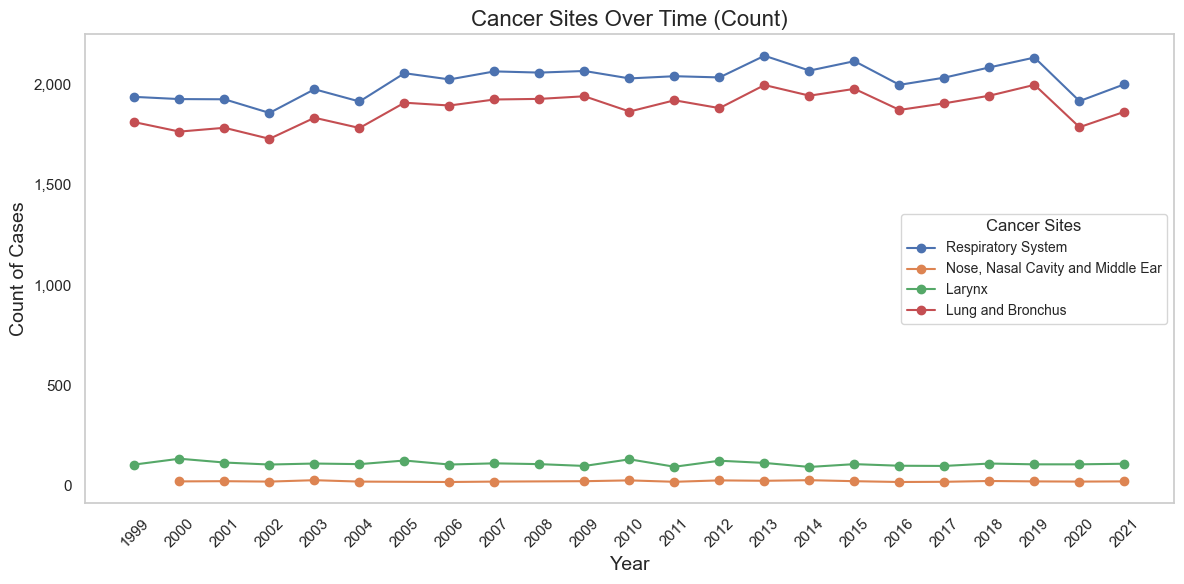

In [ ]:
cancer_subset["Year"] = pd.to_numeric(cancer_subset["Year"], errors="coerce")
cancer_subset["Count"] = pd.to_numeric(cancer_subset["Count"], errors="coerce")
cancer_subset_clean = cancer_subset.dropna(subset=["Year", "Count"])

plt.figure(figsize=(12, 6))

for cancer_site in cancer_subset_clean["Cancer Sites"].unique():
    subset = cancer_subset_clean[cancer_subset_clean["Cancer Sites"] == cancer_site]
    plt.plot(subset["Year"], subset["Count"], marker="o", linestyle="-", label=cancer_site)

plt.title("Cancer Counts Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count of Cases", fontsize=14)

unique_years = sorted(cancer_subset_clean["Year"].dropna().unique())
plt.xticks(unique_years, rotation=45)

plt.grid(False)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))


plt.legend(title="Cancer Sites", fontsize=10)

plt.tight_layout()
plt.show()


Plotting a time series for the cases of each type of cancer allows us to visualize trends and identify patterns over time. By examining the graph, we can observe that cancers associated with the respiratory system, particularly lung and bronchus cancer, have significantly higher case counts compared to cancers like larynx cancer, nose, nasal cavity, and middle ear cancer, and pleura cancer.

Next, I am interested to see if there is a correlation between smoke and these cancers.

/var/folders/tm/ktkjy58508511xl_dms3yfr80000gn/T/ipykernel_38346/1483082633.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Correlation with Estimated_Smoke", y="Cancer Sites", data=correlation_df, palette="coolwarm")


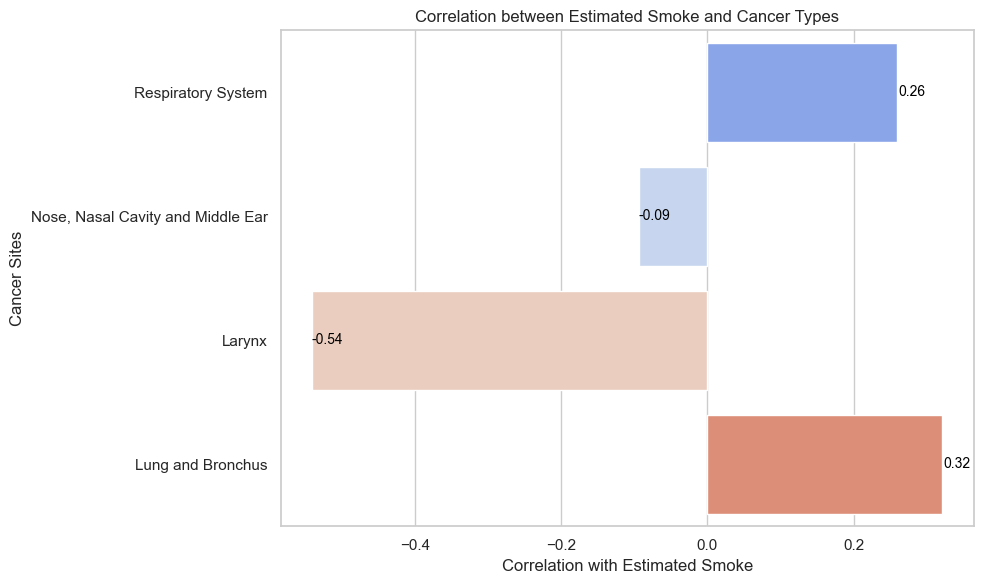

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

aggregated_df = wildfire_df.groupby("Year").agg({
    "Estimated_Smoke": "mean",  
    "Acres": "mean",             
    "Distance": "mean"          
}).reset_index()

correlation_results = []

for cancer_site in cancer_subset["Cancer Sites"].unique():
    site_data = cancer_subset[cancer_subset["Cancer Sites"] == cancer_site]
    merged_df = pd.merge(site_data, aggregated_df, on="Year", how="inner")
    merged_df = merged_df.dropna(subset=["Count", "Estimated_Smoke"])
    correlation = merged_df[["Count", "Estimated_Smoke"]].corr().iloc[0, 1]
    correlation_results.append((cancer_site, correlation))

correlation_df = pd.DataFrame(correlation_results, columns=["Cancer Sites", "Correlation with Estimated_Smoke"])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Correlation with Estimated_Smoke", y="Cancer Sites", data=correlation_df, palette="coolwarm")
plt.title("Correlation between Estimated Smoke and Cancer Types")
plt.xlabel("Correlation with Estimated Smoke")
plt.ylabel("Cancer Sites")

for p in ax.patches:
    ax.text(p.get_width() + 0.02, p.get_y() + p.get_height() / 2, 
            f'{p.get_width():.2f}', 
            ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


The results are really interesting as I did not expect there to be a negative correlation with smoke for any of these cancers. However, cancer rates are influenced by many factors such as lifestyle, and occupational exposure. At the same time, there may have been changes in public health measures for prevention. In these model, we also do no consider dealyed effects. Cancer takes years to develop, so the correlation might not be clear from a short-term dataset. 